In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [2]:
# Graphing Functions
def one_corr_heatmap(data, target_variable, title, x_label, size_var = 18, use_abs = False):
    # set size_var as a parameter with a default of 18
    plt.figure(figsize=(8,14))
    # abstract title as parameter
    plt.title(title, fontsize = size_var, pad = size_var / 2)
    
    sns.heatmap(data.corr()[[target_variable]].sort_values(by=target_variable, 
                                                           ascending = False, 
                                                           key = np.abs if use_abs else None)[1:], 
                cmap='coolwarm', vmin = -1, vmax = 1, annot = True)
    
    # abstract the "x" axis lavel as a parameter, x_label
    plt.xlabel(x_label, fontsize = size_var, labelpad = size_var/2)
    plt.xticks(fontsize=size_var/2)

    # abstract the "y" axis lavel as a parameter, y_label
    plt.yticks(fontsize=size_var/2);
    
def my_barplot(data, x_col, y_col, title, x_label, y_label, size_var = 18):
    # set size_var as a parameter with a default of 18
    plt.figure(figsize=(10,6))
    # abstract title as parameter
    plt.title(title, fontsize = size_var, pad = size_var / 2)

    # abstract the dataframe as parameter, data
    # abstract the column string for the "x" axis as a parameter, x_col
    # abstract the column string for the "y" axis as a parameter, y_col
    sns.barplot(x = data[x_col], y = data[y_col]);

    # abstract the "x" axis lavel as a parameter, x_label
    plt.xlabel(x_label, fontsize = size_var, labelpad = size_var/2)
    plt.xticks(fontsize=size_var/2, rotation=45)

    # abstract the "y" axis lavel as a parameter, y_label
    plt.ylabel(y_label, fontsize = size_var, labelpad = size_var/2)
    plt.yticks(fontsize=size_var/2, rotation=90);

In [3]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

We want to determine what attributes contribute to Sale Price. We will load the data, clean it, explor it, and create some models that hopefully predict the price.

## Cleaning

The training and testing sets are different sizes. We're going to concat them to allow for easier cleaning and possible feature transformations. Later on when creating our models, we're simply gonna split them by the index.

In [4]:
train.shape, test.shape

((2051, 81), (878, 80))

In [5]:
train_index = train.index
test_index = test.index

# create dataFrame of both training and testing data to allow for easier cleaning. Will split up later for model testing
df = pd.concat([train, test])


In [6]:
# Determing columns that have null values
na_cols = df.isnull().sum().sort_values(ascending = False)
na_cols[na_cols > 0]

Pool QC           2916
Misc Feature      2823
Alley             2731
Fence             2357
Fireplace Qu      1422
SalePrice          878
Lot Frontage       490
Garage Finish      159
Garage Qual        159
Garage Cond        159
Garage Yr Blt      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Area        23
Mas Vnr Type        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Cars          1
Garage Area          1
Total Bsmt SF        1
BsmtFin SF 2         1
Electrical           1
BsmtFin SF 1         1
Bsmt Unf SF          1
dtype: int64

There seem to be quite a few missing values. However, many of these null values are meaningful and designate the lack of said attribute. Some houses may not have a pool for example. We wish to fill in these values with either "None" or 0.

In [7]:
# Columns that designate house missing an attribute
miss_col = ['Pool QC','Misc Feature','Alley','Fence','Mas Vnr Type','Fireplace Qu',
               'Garage Qual','Garage Cond','Garage Finish','Garage Type',
               'Bsmt Exposure','Bsmt Cond','Bsmt Qual','BsmtFin Type 1','BsmtFin Type 2']

# Filling null values with 'None'
for col in miss_col:
    df[col].fillna('None',inplace=True)
    
# Garage Yr Blt will be inputed with Year Built, since they were built without a garage in the first place. 0 values would
# skew the column
df.loc[df['Garage Yr Blt'].isnull(),'Garage Yr Blt'] = df.loc[df['Garage Yr Blt'].isnull(),'Year Built']

# Masonry veneer
df['Mas Vnr Type'].fillna(0,inplace=True)

# Basement
df['Bsmt Full Bath'].fillna(0,inplace=True)
df['Bsmt Half Bath'].fillna(0,inplace=True)
df['BsmtFin SF 1'].fillna(0,inplace=True)
df['BsmtFin SF 2'].fillna(0,inplace=True)
df['Bsmt Unf SF'].fillna(0,inplace=True)
df['Total Bsmt SF'].fillna(0,inplace=True)

# Garage
df['Garage Area'].fillna(0,inplace=True)
df['Garage Cars'].fillna(0,inplace=True)



In [8]:
# Lot frontage NaN values replaced with its median
df.loc[df['Lot Frontage'].isnull(),'Lot Frontage'] = df['Lot Frontage'].median()

In [9]:
# Remaining Nan values
col_na = df.drop(columns = ['SalePrice'],axis=1).isnull().sum()
col_na = col_na[col_na>0]


rows_with_na = df.drop(columns = ['SalePrice'],axis=1).isnull().sum(axis=1)
rows_with_na = rows_with_na[rows_with_na>0]


# fill remaining nans with mode in that column
for col in col_na.index:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [10]:
# Splitting the cleaned total datafram back to training and testing sets
train_clean = df[:2051]
test_clean = df[2051:]
test_clean.drop(columns = ['SalePrice'], inplace = True)
test_clean.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(878, 80)

## EDA

Now that we're done cleaning, we're going to take all the numeric columns only and perform a correlation with our target, Sale Price, just to get an idea of what we're working with.

In [11]:
# numeric columns only, TRAINING DATA ONLY
price_corr = df.loc[:, df.dtypes != np.object][:2051]
price_corr.drop(columns = ['Id', 'PID'], inplace = True)

<ipython-input-11-4675423aa74f>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  price_corr = df.loc[:, df.dtypes != np.object][:2051]


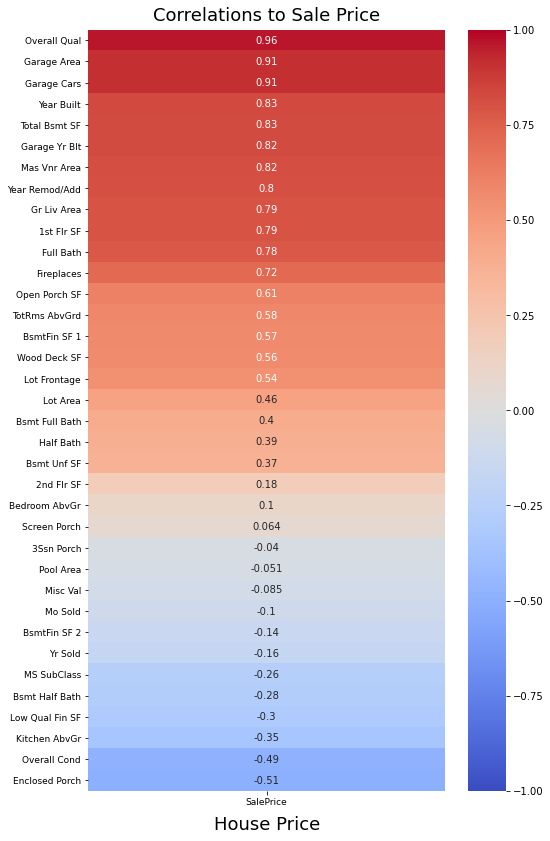

In [12]:
one_corr_heatmap(
    data = price_corr.corr(),
    target_variable='SalePrice',
    x_label = 'House Price',
    title = 'Correlations to Sale Price'
)


Overall Qual stands out as a strong indicator for price, as well as qualities that relate to the size of the property like Garage Area and more bathrooms.

Below, we can see a very clear pattern where an increase in house quality relates to an increase in price.

Text(0.5, 1.0, 'Overall Quality of Homes and Corresponding Sale Prices')

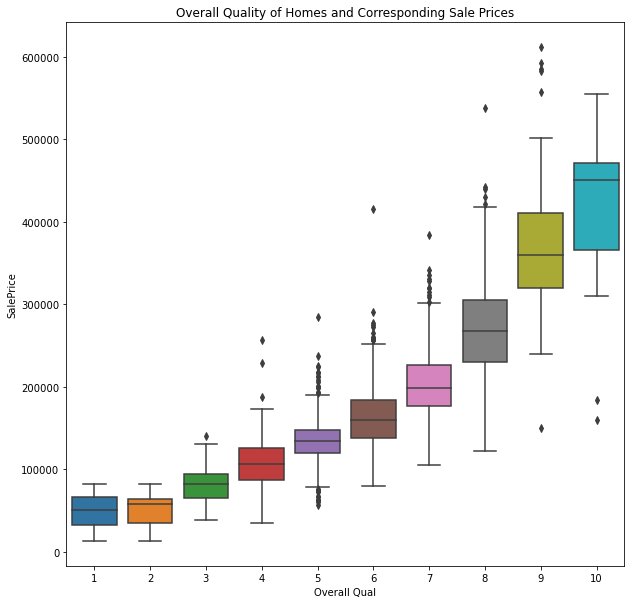

In [13]:
plt.figure(figsize = (10,10))
sns.boxplot(x = train_clean['Overall Qual'], y = train_clean['SalePrice']);
plt.title('Overall Quality of Homes and Corresponding Sale Prices')


The house condition was only a 5, but 5 means average. Most homes are average and even the most expensive ones are average. 
Still, home prices above a rating of 5 are higher than ratings under 5. 

Text(0.5, 1.0, 'Overall Condition of Homes and Corresponding Sale Prices')

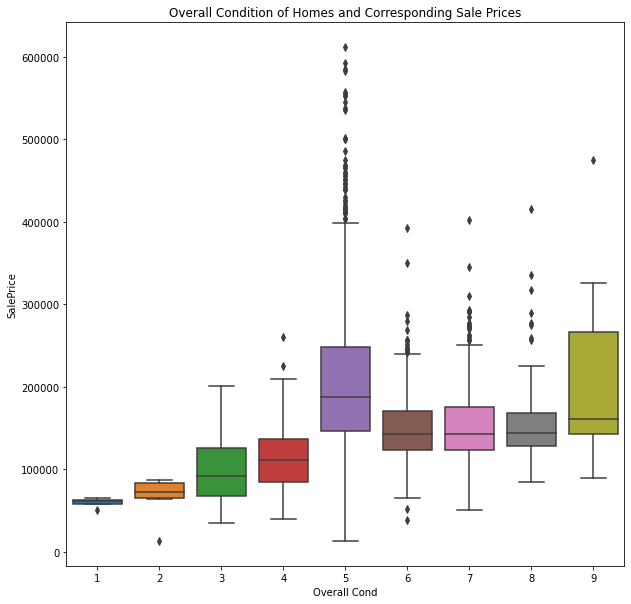

In [14]:
plt.figure(figsize = (10,10))
sns.boxplot(x = train_clean['Overall Cond'], y = train_clean['SalePrice']);
plt.title('Overall Condition of Homes and Corresponding Sale Prices')


It isn't just the quality and condition of a house that corresponds to price, Neighborhood affects it too. Higher valued neighborhoods have higher priced homes. Potential home buyers should also keep this in mind. The neighborhood one chooses sets a price that differs from area to area.

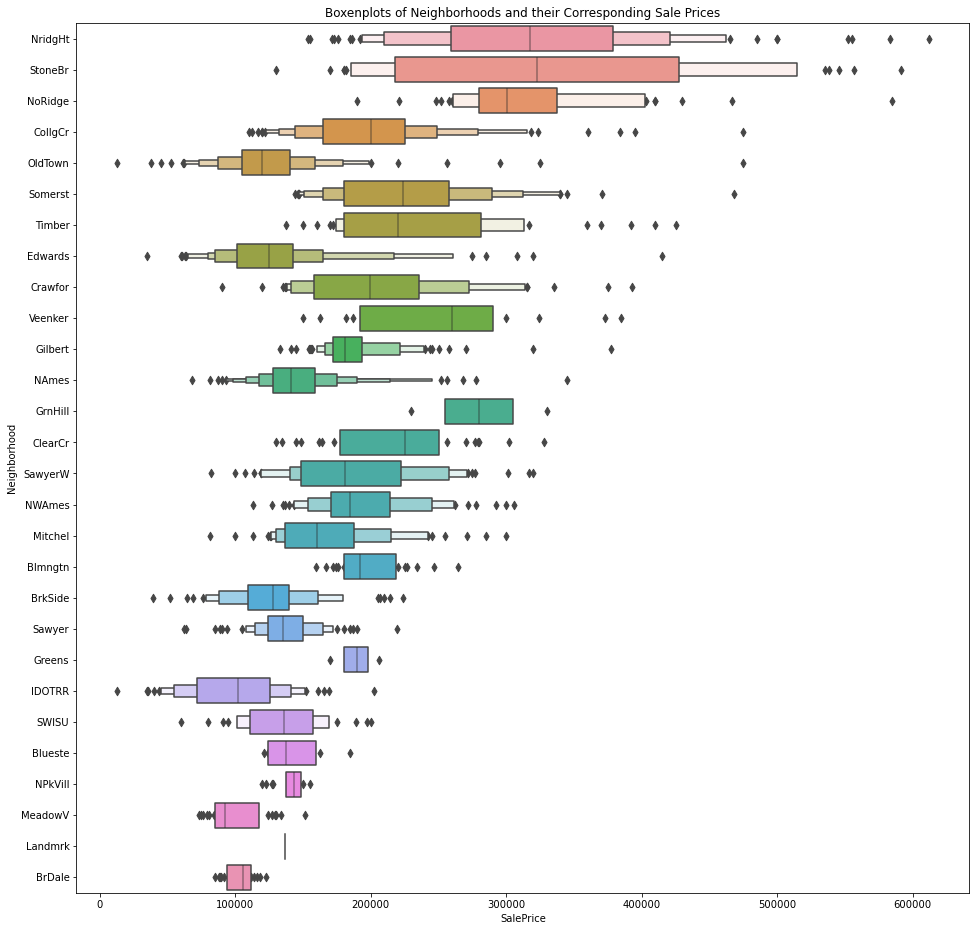

In [15]:
sort_col = train_clean.sort_values(['SalePrice'], ascending = False)

plt.figure(figsize = (16,16))
plt.title('Boxenplots of Neighborhoods and their Corresponding Sale Prices')
sns.boxenplot(y = sort_col['Neighborhood'], x = sort_col['SalePrice']);


Houses built more recently are higher priced. Cheaper homes could be older homes.

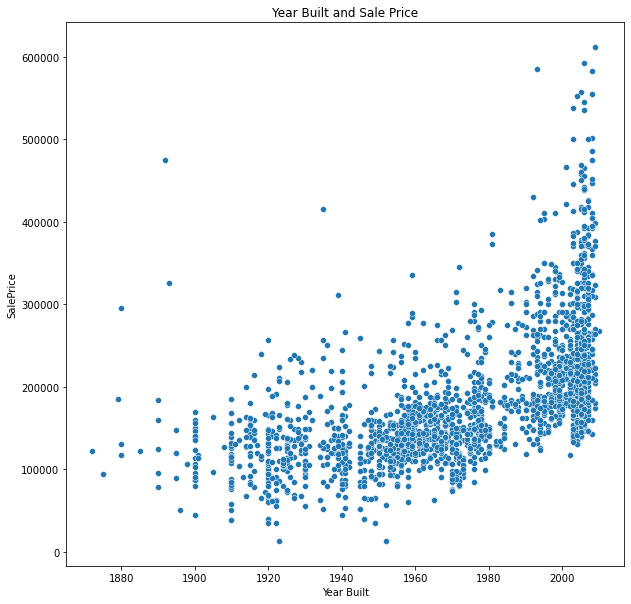

In [16]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = train_clean['Year Built'], y = train_clean['SalePrice']);
plt.title('Year Built and Sale Price');


We've got a general grasp of what numeric variables are correlating with Sale Price. So we'll start with a Linear Regression using these variables, except we'll remove any columns with an absolue correlation below 0.4 and columns that seem to be related with one another. The goal is to see how accurate the model is with the inferencing we did above.

In [17]:
# Dropping just the columns with an absolute corr < .4
price_corr.drop(columns = ['Half Bath', 'Bsmt Unf SF', '2nd Flr SF', 'Bedroom AbvGr', 'Screen Porch', '3Ssn Porch', 
                          'Pool Area', 'Misc Val', 'Mo Sold', 'BsmtFin SF 2', 'Yr Sold', 'MS SubClass', 'Bsmt Half Bath',
                          'Low Qual Fin SF', 'Kitchen AbvGr', 'SalePrice'], inplace = True)

## Performing Linear Regression

With the weak correlating variables out, we'll try out a linear regression. We'll first see if Sale Price is normally distributed.

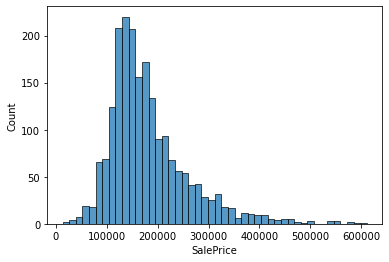

In [18]:
sns.histplot(train_clean['SalePrice']);

Right skewed, so we'll apply a log transform to normalize it 

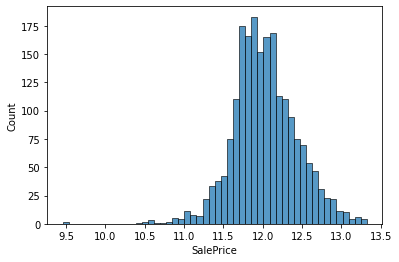

In [19]:
sns.histplot(np.log(train_clean['SalePrice']));

Seems about normal, so we'll carry on with the Linear Regression.

In [20]:
# Setting up the variables for our model
X = price_corr
y = np.log(train_clean['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [21]:
# Instantiate the model
lr = LinearRegression()

In [22]:
# Set a baseline score
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.8211141524156691

In [23]:
# Fit the model
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
# Predictions
preds = lr.predict(X)

In [25]:
# R2 scores of training and testing
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8516411467906063, 0.8713785619604992)

In [26]:
# RMSE
np.sqrt(metrics.mean_squared_error(np.exp(y), preds))

198004.31268390748

In [27]:
list(zip(price_corr.columns, np.exp(lr.coef_)))

[('Lot Frontage', 1.0003887242825615),
 ('Lot Area', 1.0000036349936943),
 ('Overall Qual', 1.0996573971366896),
 ('Overall Cond', 1.0521424452721093),
 ('Year Built', 1.002761821286464),
 ('Year Remod/Add', 1.0012784391001701),
 ('Mas Vnr Area', 1.0000064657749048),
 ('BsmtFin SF 1', 1.0000208672028366),
 ('Total Bsmt SF', 1.0000652698198322),
 ('1st Flr SF', 1.0000072951242065),
 ('Gr Liv Area', 1.0001581239426445),
 ('Bsmt Full Bath', 1.062296393886741),
 ('Full Bath', 1.0229486183504592),
 ('TotRms AbvGrd', 1.0110837728803252),
 ('Fireplaces', 1.0599507619886774),
 ('Garage Yr Blt', 1.0004698225554052),
 ('Garage Cars', 1.0614757444511822),
 ('Garage Area', 0.9999934971404524),
 ('Wood Deck SF', 1.0000324293404421),
 ('Open Porch SF', 1.000023665284215),
 ('Enclosed Porch', 1.0001802284389345)]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


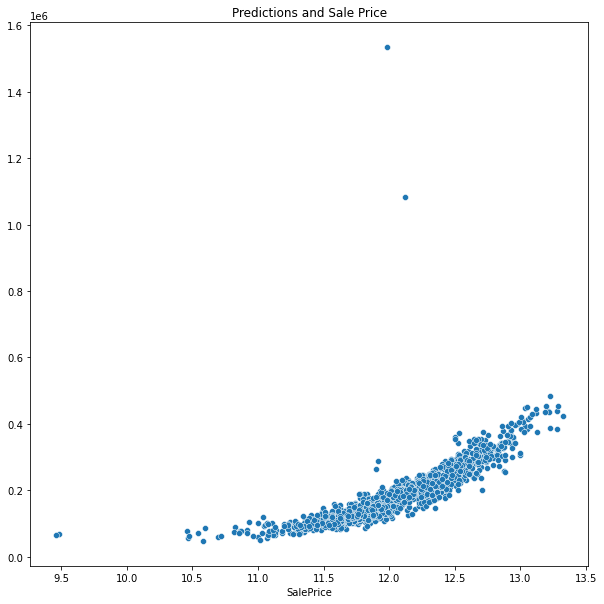

In [28]:
plt.figure(figsize = (10,10))
plt.title('Predictions and Sale Price')
sns.scatterplot(y, np.exp(preds));

Our model is doing quite well. It explains 87% of the variability in our testing data while our Root Mean Squared Error can estimate the Sale Price with a range of $19,804. The predicted prices match up to most of the actual sale prices.

Now we'll explore the categorical data and see if there are potential relationships with Sale Price that we can add to our model. Of particular interest are the other quality factors such as Exterior Quality and Kitchen Quality since we can infer that they are related to Overall Quality.

## More EDA

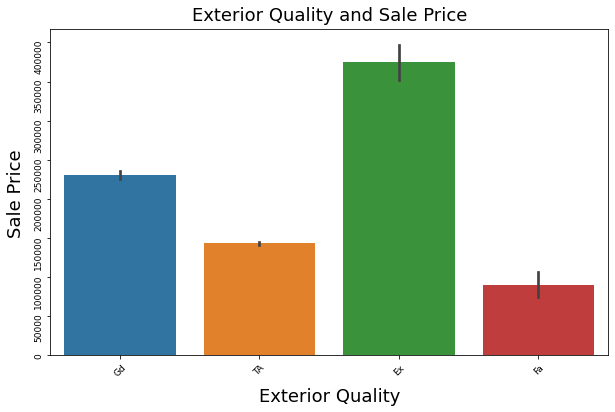

In [29]:
my_barplot(
    data = train_clean,
    x_col = "Exter Qual", 
    y_col = "SalePrice", 
    title = "Exterior Quality and Sale Price",
    x_label = "Exterior Quality",
    y_label = "Sale Price"
)

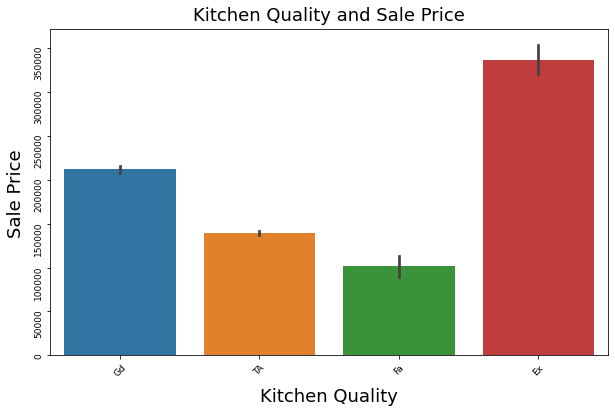

In [30]:
my_barplot(
    data = train_clean,
    x_col = "Kitchen Qual", 
    y_col = "SalePrice", 
    title = "Kitchen Quality and Sale Price",
    x_label = "Kitchen Quality",
    y_label = "Sale Price"
)

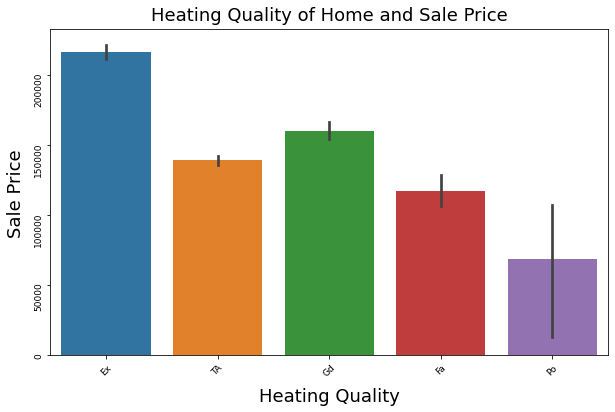

In [31]:
my_barplot(
    data = train_clean,
    x_col = "Heating QC", 
    y_col = "SalePrice", 
    title = "Heating Quality of Home and Sale Price",
    x_label = "Heating Quality",
    y_label = "Sale Price"
)

Within the individual room qualities like Kitchen Qual, the Excellent score and Good score are strongly related to Sale Price as we believed. We're onto something here, so we'll try a Ridge model.

## Ridge Testing

In [32]:
# create combined dataframe of removed numeric columns with Quality columns
temp_df = pd.DataFrame(test_clean, columns = ['Heating QC', 'Kitchen Qual', 'Garage Qual', 'Fireplace Qu', 'Exter Qual','Neighborhood'])
qual_col = pd.concat([price_corr, temp_df], axis = 1)
qual_col.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,...,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,Heating QC,Kitchen Qual,Garage Qual,Fireplace Qu,Exter Qual,Neighborhood
0,68.0,13517,6,8,1976,2005,289.0,533.0,725.0,725,...,475.0,0,44,0,Gd,Fa,Po,None,TA,OldTown
1,43.0,11492,7,5,1996,1997,132.0,637.0,913.0,913,...,559.0,0,74,0,TA,TA,TA,None,TA,Sawyer
2,68.0,7922,5,7,1953,2007,0.0,731.0,1057.0,1057,...,246.0,0,52,0,Ex,Gd,TA,Gd,Gd,Gilbert
3,73.0,9802,5,5,2006,2007,0.0,0.0,384.0,744,...,400.0,100,0,0,TA,TA,Fa,None,Gd,OldTown
4,82.0,14235,6,8,1900,1993,0.0,0.0,676.0,831,...,484.0,0,59,0,Gd,TA,TA,Gd,TA,NAmes


In [33]:
# Dummify categoricals
qual_col = pd.get_dummies(qual_col, columns = ['Heating QC', 'Kitchen Qual', 'Garage Qual', 'Fireplace Qu', 'Exter Qual', 'Neighborhood'], drop_first = True)

In [34]:
# Set up Lasso Regression
X = qual_col
y = train_clean['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [35]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [36]:
ridge_model = Ridge(alpha = 10)

In [37]:
ridge_model.fit(Xs_train, y_train)

Ridge(alpha=10)

In [38]:
ridge_model.score(Xs_train, y_train), ridge_model.score(Xs_test, y_test)

(0.8057958098514975, 0.8478623524154474)

We got lower scores with Ridge than our Linear Regression. The higher testing value indicates our model may be underfitting. We'll try a Lasso next.

## Lasso Testing

In [39]:
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

# Fit model using best ridge alpha!
lasso_cv.fit(Xs_train, y_train);

In [40]:
lasso_cv.score(Xs_train, y_train), lasso_cv.score(Xs_test, y_test)

(0.805850753665129, 0.8474526450997435)

It's very similar to our Ridge model, making our Linear Regression model the best.

## Conclusion

For the potential home buyer, house prices can be determind by examining the size of the property. If the the sheer square footage is higher, it will most likely have a higher price. The overall quality is a given as well. Homes that have higher qualities in their Kitchen and Exterior will have a greater value.
Not only that, but the neighborhood a house is located in will also have an effect on the price.
Modern homes are valued more than older homes in general. This could be due to factors outside the data provided, such as an increase in Real Estate investment.


In sum, the potential home buyer should be on the look out for when the house was built, where the house is located, how large the house is, and of what quality the home is to determine the possible sale price.

Our model was able to explain about 87% of the variability in sale price of the training dataset. It is a decent predictor of Sale Price Ames, Iowa.

## Kaggle

In [41]:
test_corr = df.loc[:, df.dtypes != np.object][2051:]
test_corr.drop(columns = ['Id', 'PID'], inplace = True)

<ipython-input-41-5d7f1148e48e>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_corr = df.loc[:, df.dtypes != np.object][2051:]


In [42]:
test_corr.drop(columns = ['Half Bath', 'Bsmt Unf SF', '2nd Flr SF', 'Bedroom AbvGr', 'Screen Porch', '3Ssn Porch', 
                          'Pool Area', 'Misc Val', 'Mo Sold', 'BsmtFin SF 2', 'Yr Sold', 'MS SubClass', 'Bsmt Half Bath',
                          'Low Qual Fin SF', 'Kitchen AbvGr', 'SalePrice'], inplace = True)

In [43]:
X_test = test_corr

In [44]:
kaggle_preds = np.exp(lr.predict(X_test))

In [45]:
kaggle_output = {'Id':test['Id'], 'SalePrice':kaggle_preds}

In [46]:
kaggle_output = pd.DataFrame(kaggle_output)

In [47]:
kaggle_output.to_csv('./submission.csv', index = False)